In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [3]:
#!/bin/bash
!curl -L -o labeled-chest-xray-images.zip https://www.kaggle.com/api/v1/datasets/download/tolgadincer/labeled-chest-xray-images

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1199M  100 1199M    0     0  21.6M      0  0:00:55  0:00:55 --:--:-- 22.4M


In [4]:
!unzip labeled-chest-xray-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-00

In [5]:
!pwd

/content


In [6]:
os.listdir('chest_xray')

['test', 'train']

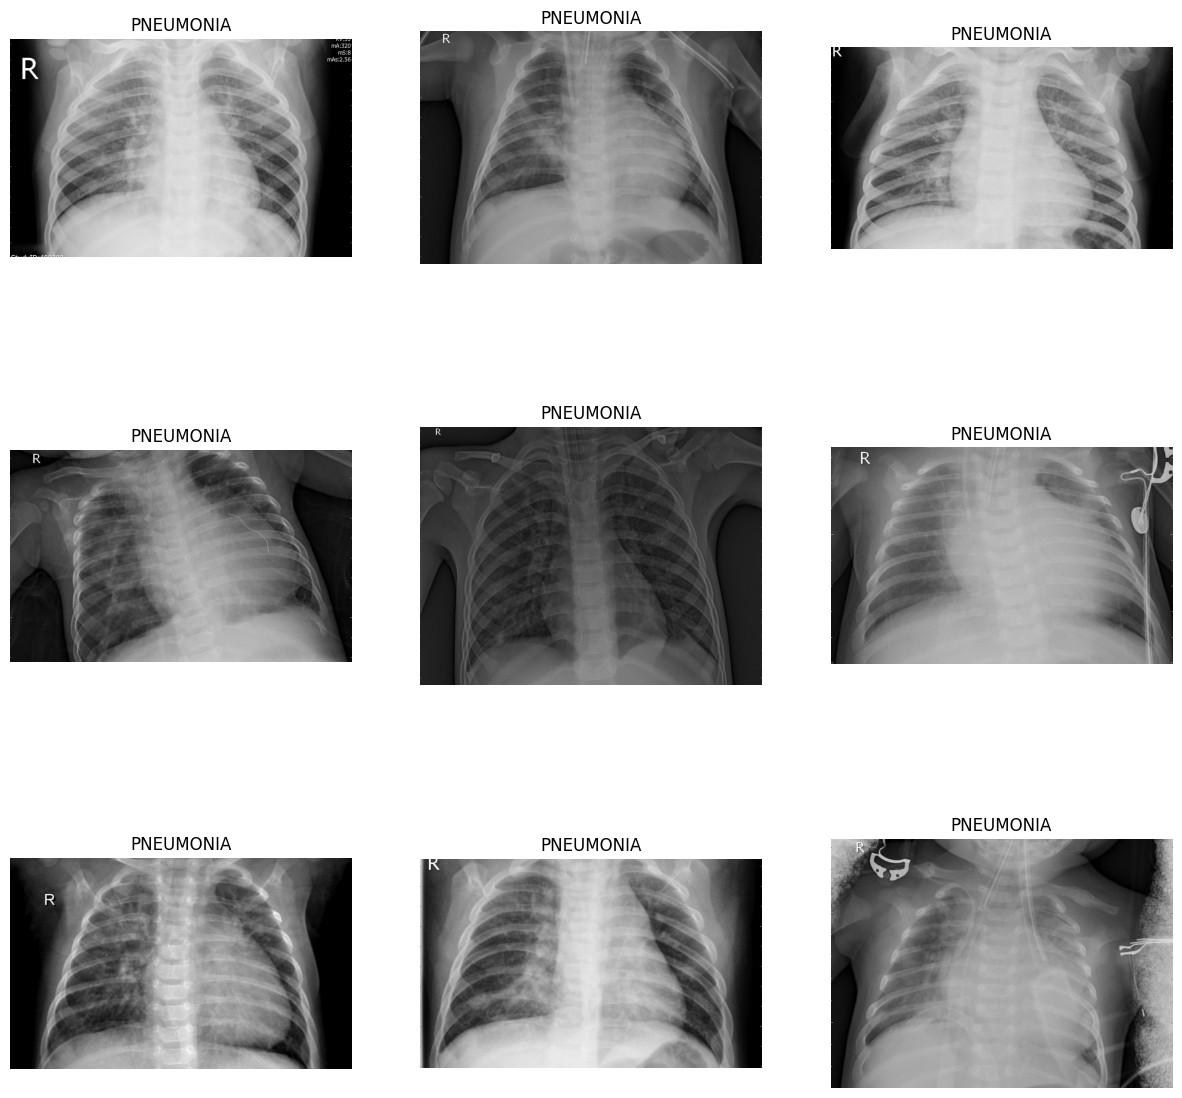

In [7]:
# Root directory after unzipping
root_dir = '/content/chest_xray'

# Collecting all image paths from both train and test
all_image_paths = []
for split in ['train', 'test']:
    split_path = os.path.join(root_dir, split)
    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    full_path = os.path.join(label_path, img_file)
                    all_image_paths.append(full_path)

# Pick 9 random images
randm_choice = np.random.choice(all_image_paths, size=9, replace=False)

# Plot
plt.figure(figsize=(15, 15))
for i in range(9):
    img = mpimg.imread(randm_choice[i])
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(os.path.basename(os.path.dirname(randm_choice[i])))
    plt.axis('off')
plt.show()


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [9]:
train_dir = '/content/chest_xray/train'
test_dir = '/content/chest_xray/test'

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (224, 224),
                                                    batch_size = 32,
                                                    class_mode = 'binary')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size = (224, 224),
                                                  batch_size = 32,
                                                  class_mode = 'binary')

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [11]:
model = tf.keras.models.Sequential([
    # Change the input_shape to match the target_size in ImageDataGenerator
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Used 'sigmoid' for binary classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,189,829 (508.08 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 88,793,220 (338.72 MB)

In [13]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 117s 668ms/step - accuracy: 0.7435 - loss: 0.8971 - val_accuracy: 0.8558 - val_loss: 0.3524
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 105s 639ms/step - accuracy: 0.8921 - loss: 0.2615 - val_accuracy: 0.8638 - val_loss: 0.2792
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 108s 657ms/step - accuracy: 0.9228 - loss: 0.1966 - val_accuracy: 0.8766 - val_loss: 0.2803
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 102s 622ms/step - accuracy: 0.9387 - loss: 0.1620 - val_accuracy: 0.8926 - val_loss: 0.2303
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 104s 631ms/step - accuracy: 0.9434 - loss: 0.1564 - val_accuracy: 0.8878 - val_loss: 0.2547
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 101s 617ms/step - accuracy: 0.9408 - loss: 0.1450 - val_accuracy: 0.8782 - val_loss: 0.2914
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 102s 620ms/step - accuracy: 0.9476 - loss: 0.1351 - val_accuracy: 0.9263 - val_loss: 0.1949
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 106s 647ms/step - accuracy: 0.9445 -

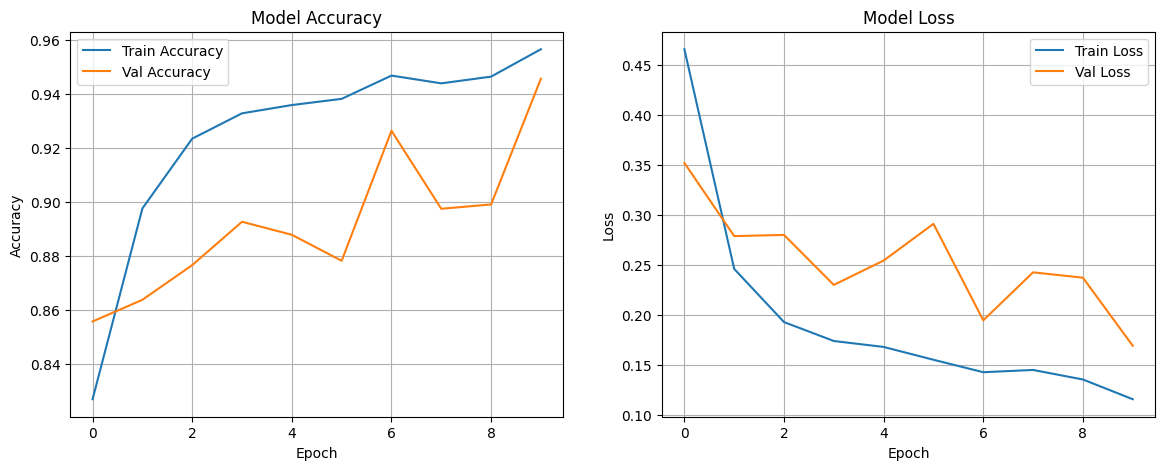

In [14]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


In [15]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - accuracy: 0.9277 - loss: 0.1965
Test Accuracy: 0.9455
Test Loss: 0.1695


In [16]:
# Get true labels
y_true = test_generator.classes

# Predict probabilities
y_pred_probs = model.predict(test_generator, verbose=1)

# Convert to class labels (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 285ms/step


              precision    recall  f1-score   support

      NORMAL       0.36      0.34      0.35       234
   PNEUMONIA       0.62      0.64      0.63       390

    accuracy                           0.53       624
   macro avg       0.49      0.49      0.49       624
weighted avg       0.52      0.53      0.53       624



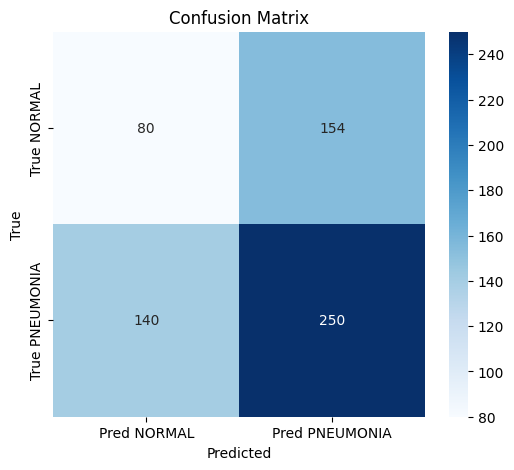

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

# Classification report
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred NORMAL', 'Pred PNEUMONIA'], yticklabels=['True NORMAL', 'True PNEUMONIA'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
